In [1]:
import random
import glob
import cv2
import os
import math
import pickle
from moviepy.editor import VideoFileClip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from scipy.ndimage.measurements import label
from multiprocessing import Pool
from skimage import color, exposure
from collections import deque

##### Global variables.
Defined below are the set of global variables which are used in the notebook.

In [72]:
dataset_path_non_vehicle = './dataset/non-vehicles/'
dataset_path_vehicle = './dataset/vehicles/'
car_features = None
noncar_features = None
images_car = []
images_noncar = []
X_test = None
Y_test = None
scaling_param = None
svc = LinearSVC(loss='hinge')
heatmap = None
# Frame coordinate windows:
coord_windows_bottom = None
coord_windows_middle = None
coord_windows_top = None
boxes_prev = []
heatmap_prev = np.zeros((720, 1280))
heatmap_deque = deque(maxlen=10)
centroid_deque = deque(maxlen=10)
default_cspace = 'YCrCb'
# keep track of centroids in terms of direction,  previous centroid, window size(w, h).
centroid_tracker = {}
prev_value = 0
cont_count = 0

frame_count = 0
model_stored = None

# Images to test the pipeline.
test_images = [
    "./test_images/test1.jpg",
    "./test_images/test2.jpg",
    "./test_images/test3.jpg",
    "./test_images/test4.jpg",
    "./test_images/test5.jpg"
]

folders_non_vehicle = [dataset_path_non_vehicle + "Extras",
                       dataset_path_non_vehicle + "GTI"]

folders_vehicle = [dataset_path_vehicle + "GTI_Far",
                   dataset_path_vehicle + "GTI_Left",  # ]
                   dataset_path_vehicle + "GTI_MiddleClose",
                   dataset_path_vehicle + "GTI_Right",
                   dataset_path_vehicle + "KITTI_extracted"]

search_ranges = {
    "bottom1": ([80, 480], [400, 680], [128, 128]),  # Tuple of search coordinates and window size.
    "bottom2": ([860, 1280], [400, 680], [128, 128]),
    "middle1": ([40, 450], [400, 500], [96, 96]),
    "middle2": ([880, 1280], [400, 500], [96, 96]),
    "top": ([400, 1280], [380, 500], [64, 64])
}

##### Helper functions
Functions below are used to extract the feature set from a given test image, used for both training and detection steps.

In [6]:
def save_model(svc, scaling_param, pixel_per_cell, cell_per_block, orient, cspace, path=None):
    global model_stored
    if path is None:
        path = './model/model.p'
    model = {
        "svc": svc,
        "scalar": scaling_param,
        "pixel_per_cell": pixel_per_cell,
        "cell_per_block": cell_per_block,
        "orient": orient,
        "cspace": cspace
    }
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    model_stored = model
    
def load_model(path=None):
    """Load a trained model."""
    model = None
    if path is None:
        path = './model/model.p'
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            model = pickle.load(f)
    return model

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draw a rectangle for given coordinates."""
    image_copy = np.copy(img)
    for box in bboxes:
        cv2.rectangle(image_copy, box[0], box[1], color, thick)
    return image_copy

def handle_colorspace(img, cspace):
    """Convert the image to given colorspace."""
    converted_img = None
    if cspace == 'YUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
    elif cspace == 'HSV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
    elif cspace == 'HLS':
        converted_img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    elif cspace == 'YCrCb':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        converted_img = img
    return converted_img

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True, transform_sqrt=False):
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt,
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt,
                       visualise=False, feature_vector=feature_vec)
        return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    feature_image = np.copy(img)
    channel1_hist = np.histogram(feature_image[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(feature_image[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(feature_image[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    feature_image = np.copy(img)
    feature_image = cv2.resize(feature_image, size, cv2.INTER_AREA )
    features = feature_image.ravel()
    return features

def single_image_features(img, hog_img=None, spatial_size=(16, 16),
                          hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                          spatial_feat=True, hist_feat=True, hog_feat=True):
    """Gather feature set for given single image as a combination of spatial, histogram and hog features."""
    # Compute spatial feature if flag is set.
    hog_features = []
    if hog_img is None and hog_feat == True:
        if hog_channel == 'ALL':
            for channel in range(img.shape[2]):
                hog_features.extend(get_hog_features(img[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block, vis=False,
                                                     feature_vec=True, transform_sqrt=True))
        else:
            hog_features = get_hog_features(img[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True,
                                            transform_sqrt=True)

    elif hog_feat == True:
        hog_features = hog_img

    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
    # Compute color histogram if flags are enabled.
    if hist_feat == True:
        hist_features = color_hist(img, nbins=hist_bins)
    img_features = np.hstack((spatial_features, hist_features, hog_features))
    return img_features

def extract_features(imgs, cspace='RGB', spatial_size=(16, 16),
                     hist_bins=32, hist_range=(0, 256), debug=False):
    features = list()
    scale = 1.5
    color_space = cspace
    spatial_size = spatial_size
    hist_bins = hist_bins
    h_range = hist_range
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    print("Extract features: Start")
    len_imgs = len(imgs)
    if imgs:
        for image in imgs:
            img = cv2.imread(image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            img = cv2.resize(img, (64, 64), cv2.INTER_AREA )
            single_feature = single_image_features(img, spatial_size=spatial_size,
                                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                   spatial_feat=spatial_feat,
                                                   hist_feat=hist_feat, hog_feat=hog_feat)
            features.append(single_feature)
    print("Extract features: End,  {0} images processed.".format(len_imgs))
    return features

def render_boxes(frame, boxlist, debug=False):
    """Draw the final bounding boxes on image."""
    for box in boxlist:
        cv2.rectangle(frame, box[0], box[1], (0, 0, 255), 6)
    if debug:
        plt.imshow(frame)
        plt.show()
    return frame

##### Retrieve and load image dataset for training.

In [7]:
def retrieve_file_names(folder):
    files = glob.glob(folder + '/' + '*.png')
    return files

def extract_combined_features(folders, cspace='RGB', spatial_size=(16, 16),
                              hist_bins=32, hist_range=(0, 256)):
    images = []
    for folder in folders:
        val = retrieve_file_names(folder)
        images = images + val
    print(len(images))
    car_features = extract_features(images, cspace, spatial_size,
                                    hist_bins, hist_range)
    return car_features, images


def extract_dataset(visualize=False):
    global car_features
    global noncar_features
    global images_car
    global images_noncar

    car_features, images_car = extract_combined_features(folders_vehicle, cspace=default_cspace, spatial_size=(16, 16),
                                                         hist_bins=32, hist_range=(0, 256))
    noncar_features, images_noncar = extract_combined_features(folders_non_vehicle, cspace=default_cspace,
                                                               spatial_size=(16, 16), hist_bins=32, hist_range=(0, 256))


Shown below are few images from car and non-car datasets.

In [20]:
def visualize_dataset(car_images, noncar_images):
    """Plot random set of images from car and non car images."""
    images = []
    car_len = len(car_images)
    noncar_len = len(noncar_images)
    car_indexes = [random.randint(0, car_len) for i in range(4)]
    noncar_indexes = [random.randint(0, noncar_len) for i in range(4)]
    fig = plt.figure(figsize=(20,10))
    plt.subplot(2, 4, 1)
    plt.imshow(mpimage.imread(car_images[car_indexes[0]]))
    images.append(car_images[car_indexes[0]])
    plt.subplot(2, 4, 2)
    plt.imshow(mpimage.imread(car_images[car_indexes[1]]))
    images.append(car_images[car_indexes[1]])
    plt.subplot(2, 4, 3)
    plt.imshow(mpimage.imread(car_images[car_indexes[2]]))
    images.append(car_images[car_indexes[2]])
    plt.subplot(2, 4, 4)
    plt.imshow(mpimage.imread(car_images[car_indexes[3]]))
    images.append(car_images[car_indexes[3]])
    plt.subplot(2, 4, 5)
    plt.imshow(mpimage.imread(noncar_images[noncar_indexes[0]]))
    images.append(noncar_images[noncar_indexes[0]])
    plt.subplot(2, 4, 6)
    plt.imshow(mpimage.imread(noncar_images[noncar_indexes[1]]))
    images.append(noncar_images[noncar_indexes[1]])
    plt.subplot(2, 4, 7)
    plt.imshow(mpimage.imread(noncar_images[noncar_indexes[2]]))
    images.append(noncar_images[noncar_indexes[2]])
    plt.subplot(2, 4, 8)
    plt.imshow(mpimage.imread(noncar_images[noncar_indexes[3]]))
    images.append(noncar_images[noncar_indexes[3]])
    fig.tight_layout()
    plt.show()
    return images

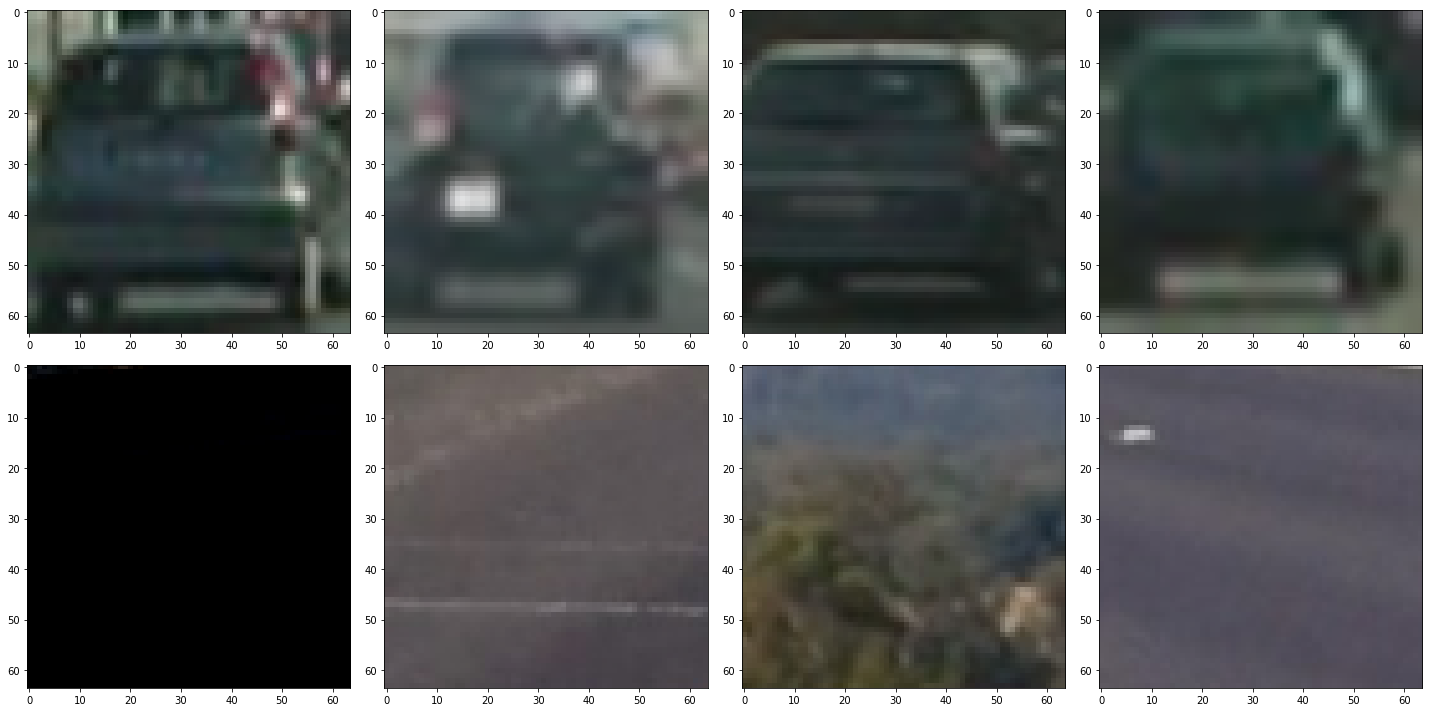

In [22]:
images_car = retrieve_file_names(folders_vehicle[0])
images_noncar = retrieve_file_names(folders_non_vehicle[0])
images = visualize_dataset(images_car, images_noncar)

Training of the model utilizes a combination of HOG features, spatial binned image segment and histogram, shown below are

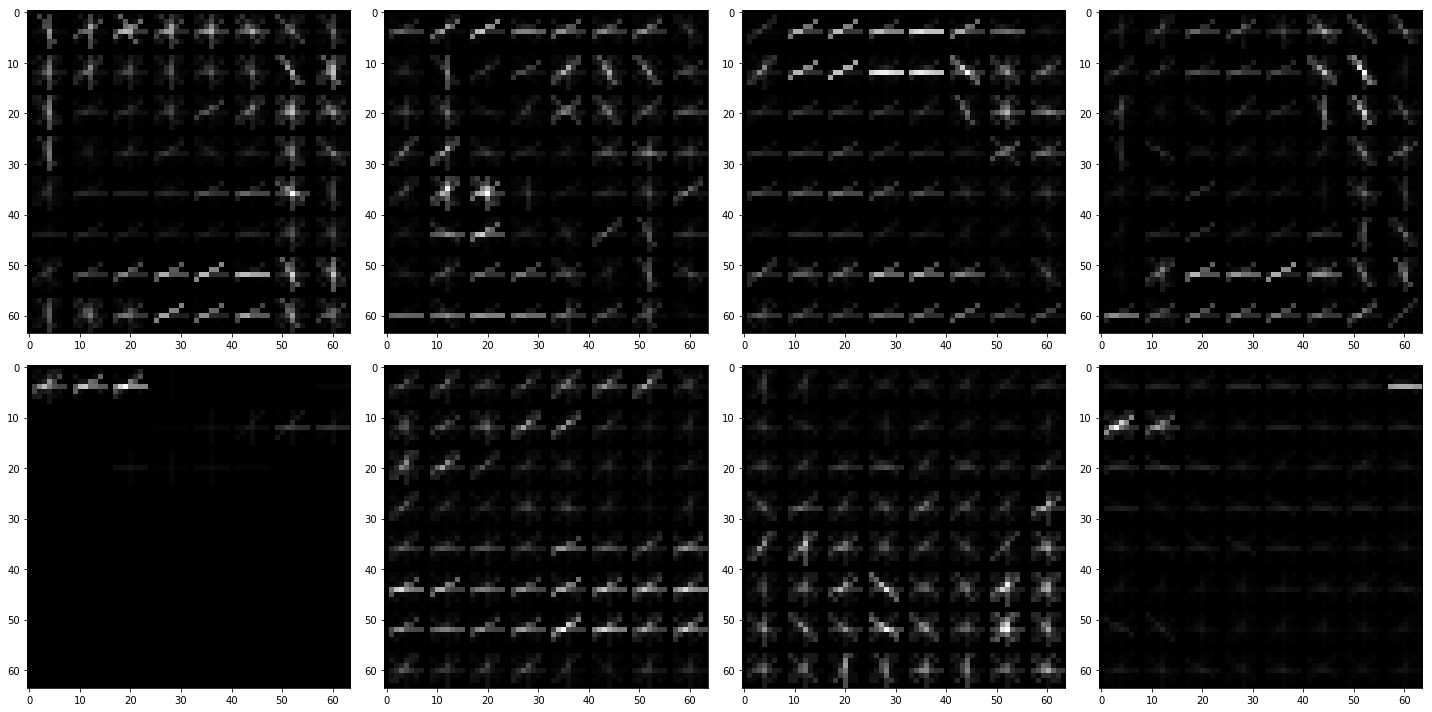

In [23]:
def test_hog(images):
    fig = plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        img = mpimage.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        orient = 8
        pix_per_cell = 8
        cell_per_block = 2
        # Call our function with vis=True to see an image output
        features, hog_image = get_hog_features(gray, orient,
                                               pix_per_cell, cell_per_block,
                                               vis=True, feature_vec=False, transform_sqrt=True)
        plt.subplot(2, 4, i+1)
        plt.imshow(hog_image, cmap='gray')
    fig.tight_layout()
    plt.show()

test_hog(images)

##### Training functions.

In [26]:
def train_model():
    global car_features
    global noncar_features
    global svc
    global X_test
    global Y_test
    global scaling_param
    print("Starting training on the dataset..\n")
    extract_dataset(False)
    Y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    scaling_param = StandardScaler().fit(X)
    X_scaled = scaling_param.transform(X)
    print("Scaled training data shape..", X_scaled.shape)
    rand_state = np.random.randint(0, 1000)
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=rand_state)
    svc.fit(X_train, Y_train)
    save_model(svc, scaling_param, 8, 2, 8, default_cspace)
    print("test accuracy: ", round(svc.score(X_test, Y_test), 4))

##### Model training.
This is the main function to start model training.

In [27]:
model_stored
if load_model() is None:
    train_model()
else:
    model_stored = load_model()

Starting training on the dataset..

8792
Extract features: Start
Extract features: End,  8792 images processed.
8968
Extract features: Start
Extract features: End,  8968 images processed.
Scaled training data shape.. (17760, 5568)
test accuracy:  0.9921


##### Sliding window functions.
Functions below are used to traverse a test image or frame as per the start, stop points and box sizes defined in global variables and detect car using the model that is trained above.

In [59]:
def sliding_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64),
                   xy_overlap=(0.5, 0.5)):
    """Implementation of a sliding window search"""
    list_overall = []  # storage
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Pixels per step in x and y direction.
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int(xy_window[1] * xy_overlap[1])
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate the window position.
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            list_overall.append(((startx, starty), (endx, endy)))
    return list_overall

def search_windows(img, windows, svc, scaling_param, hog_img=None, spatial_size=(16, 16),
                   hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):
    """Given a list of windows, search for possible detection using trained
    model and return a list of detected windows."""
    detected_windows = []
    hog_segment = []
    for window in windows:
        img_segment = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), cv2.INTER_NEAREST)
        if hog_img is not None:
            if hog_channel == 'ALL':
                for i in range(3):
                    # All three channels are enabled, copy 3 segments in order.
                    hog_segment.append(hog_img[i][window[0][1]:window[1][1], window[0][0]:window[1][0]])
                    hog_segment = np.concatenate(hog_segment)
            else:
                hog_segment = hog_img[0][window[0][1]:window[1][1], window[0][0]:window[1][0]]
        features = single_image_features(img_segment, hog_img=None, spatial_size=spatial_size,
                                         hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                         cell_per_block=cell_per_block, hog_channel=hog_channel,
                                         spatial_feat=spatial_feat,
                                         hist_feat=hist_feat, hog_feat=hog_feat)
        np_features = (features.reshape(1, -1)).astype(np.float64)
        test_features = scaling_param.transform(np_features)
        prediction = svc.predict(test_features)
        if prediction == 1:
            detected_windows.append(window)
    return detected_windows

def search_window_abstracted(frame, coord_windows):
    global svc
    global scaling_param
    global model_stored
    if model_stored is None:
        model_stored = load_model()
        
    svc = model_stored['svc']
    scaling_param = model_stored['scalar']
    pix_per_cell = model_stored['pixel_per_cell']
    cell_per_block = model_stored['cell_per_block']
    orient = model_stored['orient']
    color_space = model_stored['cspace']
    spatial_size = (16, 16)
    hist_bins = 32
    hist_range = (0, 256)
    hog_channel = 'ALL'
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    detected_windows = search_windows(frame, coord_windows, svc, scaling_param, spatial_size=spatial_size,
                                      hist_bins=hist_bins, hist_range=hist_range,
                                      orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                      hog_channel=hog_channel,
                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    return detected_windows

def get_detected_windows(frame, debug=False):
    """Get coordinates for detected windows."""
    global coord_windows_bottom
    global coord_windows_middle
    global coord_windows_top

    if coord_windows_bottom is None:
        coord_windows_bottom = sliding_window(frame, x_start_stop=search_ranges["bottom1"][0],
                                              y_start_stop=search_ranges["bottom1"][1],
                                              xy_window=search_ranges["bottom1"][2], xy_overlap=(0.6, 0.6))
        coord_windows_bottom += sliding_window(frame, x_start_stop=search_ranges["bottom2"][0],
                                               y_start_stop=search_ranges["bottom2"][1],
                                               xy_window=search_ranges["bottom2"][2], xy_overlap=(0.6, 0.6))



    if coord_windows_top is None:
        coord_windows_top = sliding_window(frame, x_start_stop=search_ranges["top"][0],
                                           y_start_stop=search_ranges["top"][1],
                                           xy_window=search_ranges["top"][2], xy_overlap=(0.6, 0.6))
    if debug:
        debug_cpy = np.copy(frame)
        debug_cpy = draw_boxes(debug_cpy, coord_windows_top, color=(255, 0, 0))
        debug_cpy = draw_boxes(debug_cpy, coord_windows_bottom, color=(0, 0, 255))
        plt.imshow(debug_cpy)
        plt.title("Search Window.")
        plt.show()

    frame = handle_colorspace(frame, default_cspace)
    detected_windows = search_window_abstracted(frame, coord_windows_bottom)
    detected_windows += search_window_abstracted(frame, coord_windows_top)
    return detected_windows

##### Test the model.
Below the model is tested on a single image frame captured from the test_video.mp4.
Both the search area used as well as detected car boxes are rendered below.

Extract features: Start
Extract features: End,  1 images processed.
Test feature length and shape:  1 -- (1, 5568)


SVC Prediction:  [ 0.]


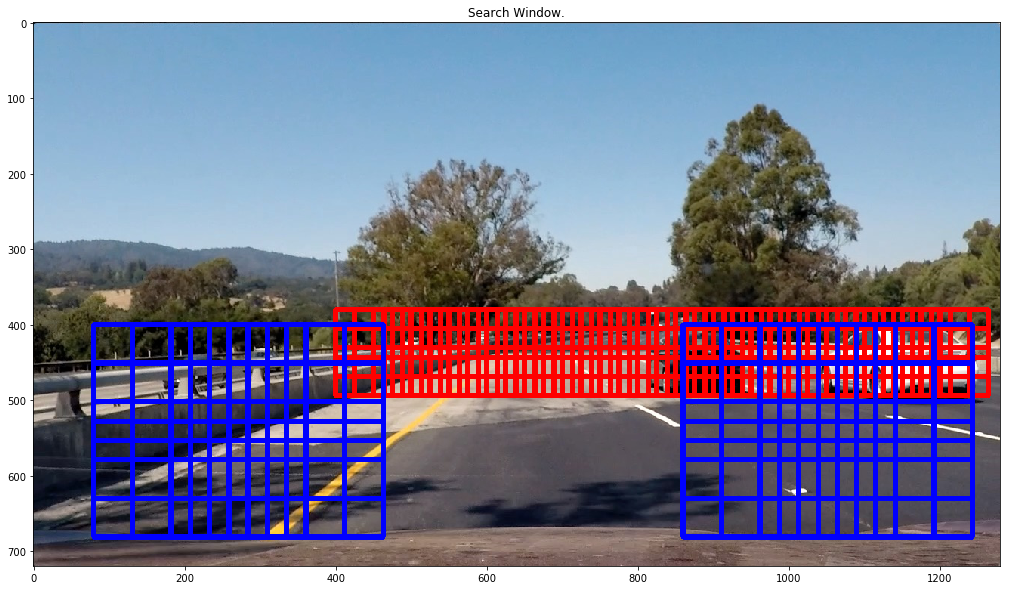

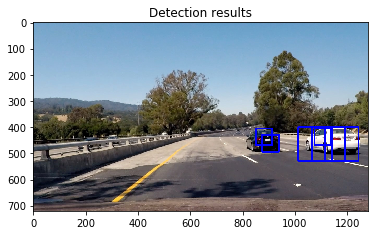

In [61]:
def test_model():
    global X_test
    global Y_test
    global svc
    global scaling_param
    global model_stored
    if model_stored is None:
        model_stored = load_model()
        
    svc = model_stored['svc']
    scaling_param = model_stored['scalar']
    pix_per_cell = model_stored['pixel_per_cell']
    cell_per_block = model_stored['cell_per_block']
    orient = model_stored['orient']
    cspace = model_stored['cspace']
    spatial_size = (16, 16)
    hist_bins = 32
    hist_range = (0, 256)
    img_path = "./test_images/non-car.png"
    feature = extract_features([img_path], cspace, spatial_size, hist_bins, hist_range, True)
    np_feature = np.array(feature)
    print("Test feature length and shape: ", len(feature), "--", np_feature.shape)
    print("\n")
    print("SVC Prediction: ", svc.predict(feature))
    frame = cv2.imread("./test_images/test4.jpg")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    boxes = get_detected_windows(frame, True)
    frame = render_boxes(frame, boxes)
    plt.imshow(frame)
    plt.title("Detection results")
    plt.show()

# Test with default test image.
test_model()

##### Thresholding functions.
Thresholding functions are used to handle overlapping boxes detected by the trained model and provide a sanitized single window depicting each of the detected car instances.
- To avoid the jitter introduced by changinf window sizes, the window sizes are clipped depending upon the position on y-axis.
- centroid() is used to determine the location of window on y-axis and depending on that window sizes are clipped to a minimum value by correct_window_size().
-  add_heat_map() and apply_threshold() are used to determine the most prominent image segment in the detected window regions.


In [67]:
def get_box_size(coord):
    window_size = 64
    if coord[1] > 550:
        window_size = 128
    elif 450 < coord[1] < 550:
        window_size = 96
    elif 400 < coord[1] < 450:
        window_size = 64
    return window_size

def centroid(coord):
    return [(coord[0][0] + coord[1][0]) // 2, (coord[0][1] + coord[1][1]) // 2]

def correct_window_size(coord):
    """Make sure windows detected maintain a minimum size."""
    cent = centroid(coord)
    x_left = coord[0][0]
    x_right = coord[1][0]
    y_top = coord[0][1]
    y_bottom = coord[1][1]
    window_width = x_right - x_left
    window_height = y_bottom - y_top
    box_size = get_box_size(cent)
    # if window_width > window_height:
    #     window_height = window_width
    # else:
    #     window_width = window_height

    if window_width < box_size:
        window_width = box_size
    if window_height < box_size:
        window_height = box_size

    x_left = cent[0] - (window_width//2)
    x_right = cent[0] + (window_width // 2)
    y_top = cent[1] - (window_height//2)
    y_bottom = cent[1] + (window_height // 2)
    return ((x_left, y_top),(x_right, y_bottom))

def add_heat_map(heatmap, bbox_list):
    """Heat map based suppression of overlapping bounding boxes."""
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    """Threshold away the weak pixels."""
    heatmap[heatmap <= threshold] = 0
    return heatmap

def get_thresholded_boxes(labels):
    """Return the thresholded bounding boxes got from heatmap."""
    global centroid_tracker
    global prev_value
    global cont_count
    bboxes = []
    if labels[1]:
        for car_number in range(1, labels[1] + 1):
            nonzero = (labels[0] == car_number).nonzero()
            # Determine X and Y values of the pixels.
            cont_count = 0
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            min_coord = (np.min(nonzerox), np.min(nonzeroy))
            max_coord = (np.max(nonzerox), np.max(nonzeroy))
            box_adjust = correct_window_size((min_coord, max_coord))
            bboxes.append(box_adjust)
    return bboxes


##### Test Thresholding functions.
Below the thresolding functions are tested on a set of test images.

In [68]:
def detect_boxes(img):
    frame = np.copy(img)
    boxes = get_detected_windows(frame, False)
    heat = np.zeros_like(frame[:, :, 0]).astype(np.float)
    heat = add_heat_map(heat, boxes)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    thres_boxes = get_thresholded_boxes(labels)
    img_thr = np.copy(frame)
    frame = render_boxes(img_thr, thres_boxes)
    return heatmap, frame

def test_thresholding_function():
    fig = plt.figure(figsize=(20,10))
    count = 1
    for index, image in enumerate(test_images):
        img = cv2.imread(image)
        conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        det_imgs = detect_boxes(conv_img)
        plt.subplot(5, 3, count)
        plt.imshow(conv_img)
        plt.subplot(5, 3, count+1)
        plt.imshow(det_imgs[0])
        plt.subplot(5, 3, count+2)
        plt.imshow(det_imgs[1])
        count += 3
    fig.tight_layout()
    plt.show()

((1064, 400), (1190, 526))
((850, 405), (938, 493))
((1064, 400), (1190, 526))
((862, 417), (926, 481))
((1105, 400), (1201, 526))
((874, 404), (938, 468))


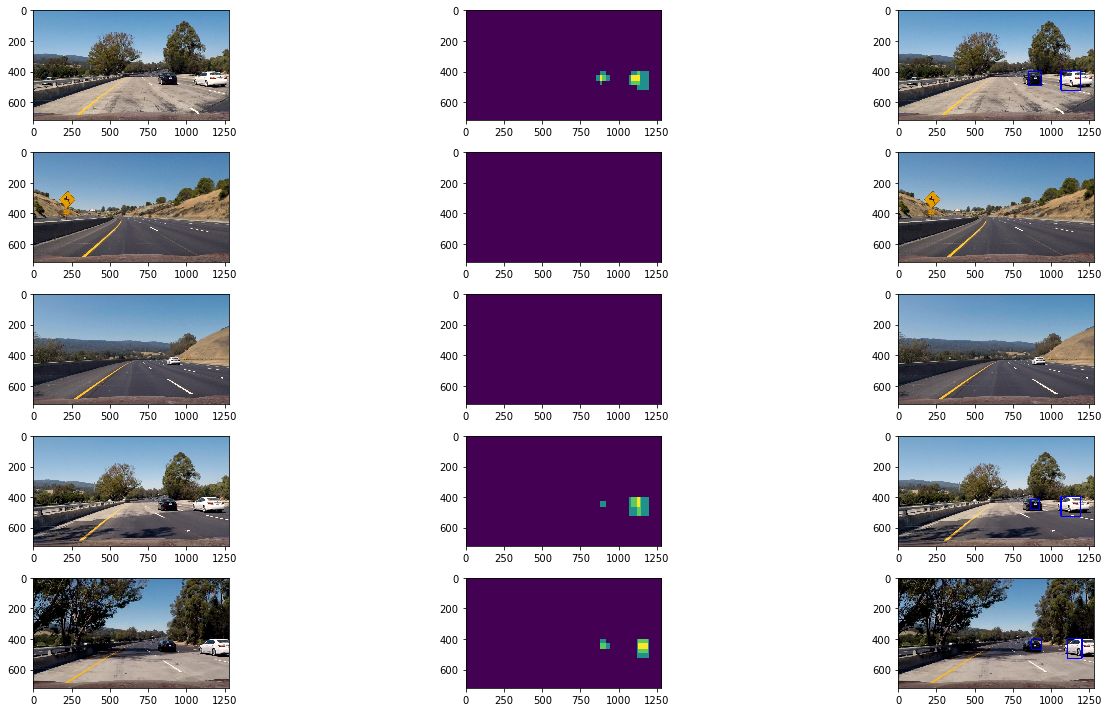

In [69]:
test_thresholding_function()

##### Video Processing pipeline.

In [73]:


def process_frame(frame):
    """Sliding window detection on the video frame."""
    global heatmap_prev
    global boxes_prev
    global frame_count
    global heatmap_deque
    bbox_list = []
    draw_boxes_on_frame = False
    heatmap_current = np.zeros_like(frame[:, :, 0]).astype(np.float)
    if frame_count % 2 == 0:
        detected_windows = get_detected_windows(frame, False)
        if len(detected_windows):
            heatmap_current = add_heat_map(heatmap_current, detected_windows)
            heatmap_deque.append(heatmap_current)
            boxes_prev = detected_windows
            heatmap_new = sum(heatmap_deque)
            heatmap_new = apply_threshold(heatmap_new, 4)
            clipped_heatmap = np.clip(heatmap_new, 0, 255)
            labels = label(clipped_heatmap)
            bbox_list = get_thresholded_boxes(labels)
            boxes_prev = bbox_list
            draw_boxes_on_frame = True
        else:
            if len(boxes_prev):
                bbox_list = boxes_prev
                draw_boxes_on_frame = True
    else:
        bbox_list = boxes_prev
        draw_boxes_on_frame = True
    frame_count += 1

    if draw_boxes_on_frame:
        frame = render_boxes(frame, bbox_list, False)
    return frame

def video_pipeline(inputpath, outputpath):
    """Main video pipeline."""
    print("Start detection pipeline..\n")
    clip = VideoFileClip(inputpath)
    output_clip = clip.fl_image(process_frame)
    output_clip.write_videofile(outputpath, audio=True)

##### Process Video.

In [74]:
video_pipeline("./videos/project_video.mp4", "./videos/output.mp4")

Start detection pipeline..

[MoviePy] >>>> Building video ./videos/output.mp4
[MoviePy] Writing audio in outputTEMP_MPY_wvf_snd.mp3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:00<00:00, 1403.76it/s]


[MoviePy] Done.
[MoviePy] Writing video ./videos/output.mp4


 13%|███████████████████▋                                                                                                                                   | 164/1261 [01:03<07:47,  2.34it/s]

((1187, 417), (1251, 481))


 13%|███████████████████▉                                                                                                                                   | 166/1261 [01:04<08:01,  2.28it/s]

((1189, 404), (1253, 468))


 13%|████████████████████                                                                                                                                   | 168/1261 [01:05<07:51,  2.32it/s]

((1175, 404), (1241, 468))


 13%|████████████████████▎                                                                                                                                  | 170/1261 [01:06<07:57,  2.29it/s]

((1175, 405), (1241, 493))


 14%|████████████████████▌                                                                                                                                  | 172/1261 [01:06<07:42,  2.36it/s]

((1175, 405), (1241, 493))


 14%|████████████████████▊                                                                                                                                  | 174/1261 [01:07<07:47,  2.33it/s]

((1115, 400), (1241, 526))


 14%|█████████████████████                                                                                                                                  | 176/1261 [01:08<07:37,  2.37it/s]

((1115, 400), (1241, 526))


 14%|█████████████████████▎                                                                                                                                 | 178/1261 [01:09<08:03,  2.24it/s]

((1115, 400), (1241, 526))


 14%|█████████████████████▌                                                                                                                                 | 180/1261 [01:10<07:46,  2.32it/s]

((1115, 400), (1241, 526))


 14%|█████████████████████▊                                                                                                                                 | 182/1261 [01:11<07:33,  2.38it/s]

((1115, 400), (1241, 526))


 15%|██████████████████████                                                                                                                                 | 184/1261 [01:11<07:24,  2.42it/s]

((1115, 400), (1241, 526))


 15%|██████████████████████▎                                                                                                                                | 186/1261 [01:12<07:19,  2.44it/s]

((1115, 400), (1241, 526))


 15%|██████████████████████▌                                                                                                                                | 188/1261 [01:13<07:46,  2.30it/s]

((1115, 400), (1241, 526))


 15%|██████████████████████▊                                                                                                                                | 190/1261 [01:14<07:41,  2.32it/s]

((1115, 400), (1241, 526))


 15%|██████████████████████▉                                                                                                                                | 192/1261 [01:15<07:42,  2.31it/s]

((1115, 400), (1241, 526))


 15%|███████████████████████▏                                                                                                                               | 194/1261 [01:16<07:38,  2.33it/s]

((1115, 400), (1241, 526))


 16%|███████████████████████▍                                                                                                                               | 196/1261 [01:17<07:35,  2.34it/s]

((1115, 400), (1241, 526))


 16%|███████████████████████▋                                                                                                                               | 198/1261 [01:17<07:30,  2.36it/s]

((1064, 400), (1242, 526))


 16%|███████████████████████▉                                                                                                                               | 200/1261 [01:19<08:04,  2.19it/s]

((1064, 400), (1242, 526))


 16%|████████████████████████▏                                                                                                                              | 202/1261 [01:19<08:01,  2.20it/s]

((1064, 400), (1242, 526))


 16%|████████████████████████▍                                                                                                                              | 204/1261 [01:20<08:01,  2.19it/s]

((1064, 400), (1242, 526))


 16%|████████████████████████▋                                                                                                                              | 206/1261 [01:21<08:02,  2.19it/s]

((1064, 400), (1242, 526))


 16%|████████████████████████▉                                                                                                                              | 208/1261 [01:22<07:57,  2.20it/s]

((1064, 400), (1242, 526))


 17%|█████████████████████████▏                                                                                                                             | 210/1261 [01:23<07:50,  2.23it/s]

((1064, 400), (1242, 526))


 17%|█████████████████████████▍                                                                                                                             | 212/1261 [01:24<07:33,  2.31it/s]

((1064, 400), (1242, 526))


 17%|█████████████████████████▋                                                                                                                             | 214/1261 [01:25<07:37,  2.29it/s]

((1064, 400), (1242, 526))


 17%|█████████████████████████▊                                                                                                                             | 216/1261 [01:26<07:36,  2.29it/s]

((1064, 400), (1242, 526))


 17%|██████████████████████████                                                                                                                             | 218/1261 [01:27<07:51,  2.21it/s]

((1064, 400), (1242, 526))


 17%|██████████████████████████▎                                                                                                                            | 220/1261 [01:28<08:18,  2.09it/s]

((1064, 400), (1242, 526))


 18%|██████████████████████████▌                                                                                                                            | 222/1261 [01:29<08:14,  2.10it/s]

((1064, 400), (1242, 526))


 18%|██████████████████████████▊                                                                                                                            | 224/1261 [01:29<08:04,  2.14it/s]

((1064, 400), (1242, 526))


 18%|███████████████████████████                                                                                                                            | 226/1261 [01:30<07:55,  2.18it/s]

((1064, 400), (1242, 526))


 18%|███████████████████████████▎                                                                                                                           | 228/1261 [01:31<07:57,  2.16it/s]

((1064, 400), (1242, 526))


 18%|███████████████████████████▌                                                                                                                           | 230/1261 [01:32<07:52,  2.18it/s]

((1064, 400), (1242, 526))


 18%|███████████████████████████▊                                                                                                                           | 232/1261 [01:33<08:00,  2.14it/s]

((1064, 400), (1242, 526))


 19%|████████████████████████████                                                                                                                           | 234/1261 [01:34<07:50,  2.18it/s]

((1064, 400), (1242, 526))


 19%|████████████████████████████▎                                                                                                                          | 236/1261 [01:35<07:40,  2.23it/s]

((1064, 400), (1242, 526))


 19%|████████████████████████████▍                                                                                                                          | 238/1261 [01:36<07:30,  2.27it/s]

((1050, 400), (1242, 526))


 19%|████████████████████████████▋                                                                                                                          | 240/1261 [01:37<07:19,  2.32it/s]

((1050, 400), (1242, 526))


 19%|████████████████████████████▉                                                                                                                          | 242/1261 [01:37<07:17,  2.33it/s]

((1050, 400), (1242, 526))


 19%|█████████████████████████████▏                                                                                                                         | 244/1261 [01:38<07:09,  2.37it/s]

((1050, 400), (1242, 526))


 20%|█████████████████████████████▍                                                                                                                         | 246/1261 [01:39<07:11,  2.35it/s]

((1013, 400), (1241, 526))


 20%|█████████████████████████████▋                                                                                                                         | 248/1261 [01:40<07:17,  2.32it/s]

((1013, 400), (1241, 526))


 20%|█████████████████████████████▉                                                                                                                         | 250/1261 [01:41<07:17,  2.31it/s]

((1013, 400), (1241, 526))


 20%|██████████████████████████████▏                                                                                                                        | 252/1261 [01:42<07:13,  2.33it/s]

((1013, 400), (1241, 526))


 20%|██████████████████████████████▍                                                                                                                        | 254/1261 [01:43<07:07,  2.36it/s]

((1013, 400), (1241, 526))


 20%|██████████████████████████████▋                                                                                                                        | 256/1261 [01:43<07:01,  2.38it/s]

((1013, 400), (1241, 526))


 20%|██████████████████████████████▉                                                                                                                        | 258/1261 [01:44<06:55,  2.41it/s]

((1013, 400), (1241, 526))


 21%|███████████████████████████████▏                                                                                                                       | 260/1261 [01:45<06:53,  2.42it/s]

((1013, 400), (1241, 526))


 21%|███████████████████████████████▎                                                                                                                       | 262/1261 [01:46<06:51,  2.43it/s]

((1013, 400), (1241, 526))


 21%|███████████████████████████████▌                                                                                                                       | 264/1261 [01:47<06:51,  2.42it/s]

((1013, 400), (1241, 526))


 21%|███████████████████████████████▊                                                                                                                       | 266/1261 [01:47<06:53,  2.40it/s]

((1013, 400), (1241, 526))


 21%|████████████████████████████████                                                                                                                       | 268/1261 [01:48<06:58,  2.37it/s]

((1013, 400), (1241, 526))


 21%|████████████████████████████████▎                                                                                                                      | 270/1261 [01:49<06:53,  2.39it/s]

((1013, 400), (1241, 526))


 22%|████████████████████████████████▌                                                                                                                      | 272/1261 [01:50<06:49,  2.42it/s]

((1013, 400), (1241, 526))


 22%|████████████████████████████████▊                                                                                                                      | 274/1261 [01:51<06:52,  2.39it/s]

((1013, 400), (1241, 526))


 22%|█████████████████████████████████                                                                                                                      | 276/1261 [01:52<06:54,  2.38it/s]

((1013, 400), (1241, 526))


 22%|█████████████████████████████████▎                                                                                                                     | 278/1261 [01:52<06:48,  2.41it/s]

((1013, 400), (1241, 526))


 22%|█████████████████████████████████▌                                                                                                                     | 280/1261 [01:53<06:46,  2.41it/s]

((1013, 400), (1241, 526))


 22%|█████████████████████████████████▊                                                                                                                     | 282/1261 [01:54<06:44,  2.42it/s]

((1013, 400), (1241, 526))


 23%|██████████████████████████████████                                                                                                                     | 284/1261 [01:55<06:42,  2.43it/s]

((1013, 400), (1241, 526))


 23%|██████████████████████████████████▏                                                                                                                    | 286/1261 [01:56<06:45,  2.41it/s]

((1013, 400), (1241, 526))


 23%|██████████████████████████████████▍                                                                                                                    | 288/1261 [01:57<06:46,  2.40it/s]

((1013, 400), (1241, 526))


 23%|██████████████████████████████████▋                                                                                                                    | 290/1261 [01:57<06:45,  2.40it/s]

((1013, 400), (1241, 526))


 23%|██████████████████████████████████▉                                                                                                                    | 292/1261 [01:58<06:43,  2.40it/s]

((1013, 400), (1241, 526))


 23%|███████████████████████████████████▏                                                                                                                   | 294/1261 [01:59<06:42,  2.41it/s]

((1013, 400), (1241, 526))


 23%|███████████████████████████████████▍                                                                                                                   | 296/1261 [02:00<06:40,  2.41it/s]

((1013, 400), (1241, 526))


 24%|███████████████████████████████████▋                                                                                                                   | 298/1261 [02:01<06:40,  2.40it/s]

((1013, 400), (1241, 526))


 24%|███████████████████████████████████▉                                                                                                                   | 300/1261 [02:02<06:38,  2.41it/s]

((1013, 400), (1241, 526))


 24%|████████████████████████████████████▏                                                                                                                  | 302/1261 [02:02<06:33,  2.44it/s]

((1013, 400), (1241, 526))


 24%|████████████████████████████████████▍                                                                                                                  | 304/1261 [02:03<06:33,  2.43it/s]

((1013, 400), (1241, 526))


 24%|████████████████████████████████████▋                                                                                                                  | 306/1261 [02:04<06:32,  2.44it/s]

((1013, 400), (1241, 526))


 24%|████████████████████████████████████▉                                                                                                                  | 308/1261 [02:05<06:31,  2.43it/s]

((1013, 400), (1241, 526))


 25%|█████████████████████████████████████                                                                                                                  | 310/1261 [02:06<06:28,  2.45it/s]

((1013, 400), (1213, 526))


 25%|█████████████████████████████████████▎                                                                                                                 | 312/1261 [02:06<06:27,  2.45it/s]

((1013, 400), (1213, 526))


 25%|█████████████████████████████████████▌                                                                                                                 | 314/1261 [02:07<06:27,  2.44it/s]

((1013, 400), (1213, 526))


 25%|█████████████████████████████████████▊                                                                                                                 | 316/1261 [02:08<06:26,  2.45it/s]

((1013, 400), (1191, 526))


 25%|██████████████████████████████████████                                                                                                                 | 318/1261 [02:09<06:30,  2.41it/s]

((1000, 400), (1190, 526))


 25%|██████████████████████████████████████▎                                                                                                                | 320/1261 [02:10<06:32,  2.40it/s]

((1000, 400), (1190, 526))


 26%|██████████████████████████████████████▌                                                                                                                | 322/1261 [02:11<06:32,  2.39it/s]

((1000, 400), (1190, 526))


 26%|██████████████████████████████████████▊                                                                                                                | 324/1261 [02:11<06:27,  2.42it/s]

((1000, 400), (1190, 526))


 26%|███████████████████████████████████████                                                                                                                | 326/1261 [02:12<06:24,  2.43it/s]

((1000, 400), (1190, 526))


 26%|███████████████████████████████████████▎                                                                                                               | 328/1261 [02:13<06:22,  2.44it/s]

((1000, 400), (1190, 526))


 26%|███████████████████████████████████████▌                                                                                                               | 330/1261 [02:14<06:21,  2.44it/s]

((1000, 400), (1190, 526))


 26%|███████████████████████████████████████▊                                                                                                               | 332/1261 [02:15<06:20,  2.44it/s]

((1000, 400), (1190, 526))


 26%|███████████████████████████████████████▉                                                                                                               | 334/1261 [02:16<06:19,  2.44it/s]

((1000, 400), (1190, 526))


 27%|████████████████████████████████████████▏                                                                                                              | 336/1261 [02:16<06:17,  2.45it/s]

((1000, 400), (1190, 526))


 27%|████████████████████████████████████████▍                                                                                                              | 338/1261 [02:17<06:13,  2.47it/s]

((962, 400), (1190, 526))


 27%|████████████████████████████████████████▋                                                                                                              | 340/1261 [02:18<06:12,  2.47it/s]

((962, 400), (1190, 526))


 27%|████████████████████████████████████████▉                                                                                                              | 342/1261 [02:19<06:12,  2.46it/s]

((962, 400), (1190, 526))


 27%|█████████████████████████████████████████▏                                                                                                             | 344/1261 [02:20<06:16,  2.43it/s]

((962, 400), (1190, 526))


 27%|█████████████████████████████████████████▍                                                                                                             | 346/1261 [02:20<06:16,  2.43it/s]

((962, 400), (1190, 526))


 28%|█████████████████████████████████████████▋                                                                                                             | 348/1261 [02:21<06:21,  2.40it/s]

((962, 400), (1190, 526))


 28%|█████████████████████████████████████████▉                                                                                                             | 350/1261 [02:22<06:22,  2.38it/s]

((962, 400), (1190, 526))


 28%|██████████████████████████████████████████▏                                                                                                            | 352/1261 [02:23<06:24,  2.37it/s]

((962, 400), (1190, 526))


 28%|██████████████████████████████████████████▍                                                                                                            | 354/1261 [02:24<06:23,  2.37it/s]

((962, 400), (1190, 526))


 28%|██████████████████████████████████████████▋                                                                                                            | 356/1261 [02:25<06:20,  2.38it/s]

((962, 400), (1190, 526))


 28%|██████████████████████████████████████████▊                                                                                                            | 358/1261 [02:26<06:18,  2.39it/s]

((962, 400), (1190, 526))


 29%|███████████████████████████████████████████                                                                                                            | 360/1261 [02:26<06:15,  2.40it/s]

((962, 400), (1162, 526))


 29%|███████████████████████████████████████████▎                                                                                                           | 362/1261 [02:27<06:11,  2.42it/s]

((962, 400), (1162, 526))


 29%|███████████████████████████████████████████▌                                                                                                           | 364/1261 [02:28<06:07,  2.44it/s]

((962, 400), (1162, 526))


 29%|███████████████████████████████████████████▊                                                                                                           | 366/1261 [02:29<06:03,  2.46it/s]

((962, 400), (1140, 526))


 29%|████████████████████████████████████████████                                                                                                           | 368/1261 [02:30<06:02,  2.46it/s]

((962, 400), (1140, 526))


 29%|████████████████████████████████████████████▎                                                                                                          | 370/1261 [02:30<06:03,  2.45it/s]

((962, 400), (1140, 526))


 30%|████████████████████████████████████████████▌                                                                                                          | 372/1261 [02:31<06:07,  2.42it/s]

((962, 400), (1140, 526))


 30%|████████████████████████████████████████████▊                                                                                                          | 374/1261 [02:32<06:08,  2.41it/s]

((962, 400), (1140, 526))


 30%|█████████████████████████████████████████████                                                                                                          | 376/1261 [02:33<06:07,  2.41it/s]

((962, 400), (1140, 526))


 30%|█████████████████████████████████████████████▎                                                                                                         | 378/1261 [02:34<06:07,  2.41it/s]

((962, 400), (1140, 526))


 30%|█████████████████████████████████████████████▌                                                                                                         | 380/1261 [02:35<06:07,  2.39it/s]

((962, 400), (1140, 526))


 30%|█████████████████████████████████████████████▋                                                                                                         | 382/1261 [02:35<06:08,  2.38it/s]

((962, 400), (1140, 526))


 30%|█████████████████████████████████████████████▉                                                                                                         | 384/1261 [02:36<06:10,  2.36it/s]

((950, 400), (1140, 526))


 31%|██████████████████████████████████████████████▏                                                                                                        | 386/1261 [02:37<06:07,  2.38it/s]

((950, 400), (1140, 526))


 31%|██████████████████████████████████████████████▍                                                                                                        | 388/1261 [02:38<06:05,  2.39it/s]

((950, 400), (1140, 526))


 31%|██████████████████████████████████████████████▋                                                                                                        | 390/1261 [02:39<06:02,  2.40it/s]

((950, 400), (1112, 526))


 31%|██████████████████████████████████████████████▉                                                                                                        | 392/1261 [02:40<05:58,  2.42it/s]

((950, 400), (1112, 526))


 31%|███████████████████████████████████████████████▏                                                                                                       | 394/1261 [02:40<05:58,  2.42it/s]

((950, 400), (1112, 526))


 31%|███████████████████████████████████████████████▍                                                                                                       | 396/1261 [02:41<05:56,  2.43it/s]

((950, 400), (1112, 526))


 32%|███████████████████████████████████████████████▋                                                                                                       | 398/1261 [02:42<05:54,  2.44it/s]

((950, 400), (1112, 526))


 32%|███████████████████████████████████████████████▉                                                                                                       | 400/1261 [02:43<05:50,  2.46it/s]

((950, 400), (1088, 526))


 32%|████████████████████████████████████████████████▏                                                                                                      | 402/1261 [02:44<05:50,  2.45it/s]

((925, 400), (1089, 526))


 32%|████████████████████████████████████████████████▍                                                                                                      | 404/1261 [02:44<05:48,  2.46it/s]

((925, 400), (1089, 526))


 32%|████████████████████████████████████████████████▌                                                                                                      | 406/1261 [02:45<05:46,  2.47it/s]

((925, 400), (1089, 526))


 32%|████████████████████████████████████████████████▊                                                                                                      | 408/1261 [02:46<05:48,  2.45it/s]

((925, 400), (1089, 526))


 33%|█████████████████████████████████████████████████                                                                                                      | 410/1261 [02:47<05:50,  2.43it/s]

((925, 400), (1089, 526))


 33%|█████████████████████████████████████████████████▎                                                                                                     | 412/1261 [02:48<05:48,  2.44it/s]

((925, 400), (1089, 526))


 33%|█████████████████████████████████████████████████▌                                                                                                     | 414/1261 [02:49<05:50,  2.42it/s]

((925, 400), (1089, 526))


 33%|█████████████████████████████████████████████████▊                                                                                                     | 416/1261 [02:49<05:46,  2.44it/s]

((925, 400), (1063, 526))


 33%|██████████████████████████████████████████████████                                                                                                     | 418/1261 [02:50<05:44,  2.45it/s]

((925, 400), (1063, 526))


 33%|██████████████████████████████████████████████████▌                                                                                                    | 422/1261 [02:52<05:33,  2.52it/s]

((925, 400), (1063, 526))


 34%|███████████████████████████████████████████████████                                                                                                    | 426/1261 [02:53<05:27,  2.55it/s]

((911, 400), (1037, 526))


 34%|███████████████████████████████████████████████████▎                                                                                                   | 428/1261 [02:54<05:34,  2.49it/s]

((911, 400), (1037, 526))


 34%|███████████████████████████████████████████████████▍                                                                                                   | 430/1261 [02:55<05:37,  2.46it/s]

((911, 400), (1037, 526))


 34%|███████████████████████████████████████████████████▋                                                                                                   | 432/1261 [02:56<05:35,  2.47it/s]

((911, 400), (1037, 526))


 34%|███████████████████████████████████████████████████▉                                                                                                   | 434/1261 [02:57<05:35,  2.47it/s]

((911, 400), (1037, 526))


 35%|████████████████████████████████████████████████████▏                                                                                                  | 436/1261 [02:57<05:35,  2.46it/s]

((911, 400), (1037, 526))


 35%|████████████████████████████████████████████████████▍                                                                                                  | 438/1261 [02:58<05:36,  2.45it/s]

((911, 400), (1037, 526))


 35%|████████████████████████████████████████████████████▋                                                                                                  | 440/1261 [02:59<05:41,  2.41it/s]

((911, 400), (1037, 526))


 35%|████████████████████████████████████████████████████▉                                                                                                  | 442/1261 [03:00<05:38,  2.42it/s]

((911, 400), (1037, 526))


 35%|█████████████████████████████████████████████████████▏                                                                                                 | 444/1261 [03:01<05:42,  2.39it/s]

((911, 400), (1037, 526))


 35%|█████████████████████████████████████████████████████▍                                                                                                 | 446/1261 [03:02<05:45,  2.36it/s]

((900, 400), (1038, 526))


 36%|█████████████████████████████████████████████████████▋                                                                                                 | 448/1261 [03:03<05:47,  2.34it/s]

((900, 400), (1038, 526))


 36%|█████████████████████████████████████████████████████▉                                                                                                 | 450/1261 [03:03<05:46,  2.34it/s]

((900, 400), (1038, 526))


 36%|██████████████████████████████████████████████████████▏                                                                                                | 452/1261 [03:04<05:45,  2.34it/s]

((900, 400), (1038, 526))


 36%|██████████████████████████████████████████████████████▎                                                                                                | 454/1261 [03:05<05:41,  2.36it/s]

((900, 400), (1038, 526))


 36%|██████████████████████████████████████████████████████▌                                                                                                | 456/1261 [03:06<05:37,  2.39it/s]

((900, 400), (1038, 526))


 36%|██████████████████████████████████████████████████████▊                                                                                                | 458/1261 [03:07<05:35,  2.40it/s]

((900, 400), (1038, 526))


 36%|███████████████████████████████████████████████████████                                                                                                | 460/1261 [03:08<05:33,  2.40it/s]

((900, 400), (1038, 526))


 37%|███████████████████████████████████████████████████████▎                                                                                               | 462/1261 [03:08<05:29,  2.42it/s]

((911, 400), (1037, 526))


 37%|███████████████████████████████████████████████████████▌                                                                                               | 464/1261 [03:09<05:25,  2.45it/s]

((900, 400), (1038, 526))


 37%|███████████████████████████████████████████████████████▊                                                                                               | 466/1261 [03:10<05:26,  2.43it/s]

((911, 400), (1037, 526))


 37%|████████████████████████████████████████████████████████                                                                                               | 468/1261 [03:11<05:33,  2.38it/s]

((900, 400), (1038, 526))


 37%|████████████████████████████████████████████████████████▎                                                                                              | 470/1261 [03:12<05:31,  2.39it/s]

((900, 400), (1038, 526))


 37%|████████████████████████████████████████████████████████▌                                                                                              | 472/1261 [03:13<05:31,  2.38it/s]

((900, 400), (1038, 526))


 38%|█████████████████████████████████████████████████████████▏                                                                                             | 478/1261 [03:15<05:16,  2.47it/s]

((900, 400), (1038, 526))


 38%|█████████████████████████████████████████████████████████▍                                                                                             | 480/1261 [03:16<05:20,  2.44it/s]

((900, 400), (1038, 526))


 39%|██████████████████████████████████████████████████████████▏                                                                                            | 486/1261 [03:18<05:08,  2.51it/s]

((900, 400), (1038, 526))


 39%|██████████████████████████████████████████████████████████▍                                                                                            | 488/1261 [03:19<05:11,  2.48it/s]

((900, 400), (1038, 526))


 39%|██████████████████████████████████████████████████████████▉                                                                                            | 492/1261 [03:21<05:16,  2.43it/s]

((900, 400), (1038, 526))


 39%|███████████████████████████████████████████████████████████▍                                                                                           | 496/1261 [03:22<05:09,  2.47it/s]

((900, 400), (1038, 526))


 39%|███████████████████████████████████████████████████████████▋                                                                                           | 498/1261 [03:23<05:08,  2.47it/s]

((900, 400), (1038, 526))


 40%|███████████████████████████████████████████████████████████▊                                                                                           | 500/1261 [03:24<05:08,  2.47it/s]

((900, 405), (1038, 493))


 40%|████████████████████████████████████████████████████████████                                                                                           | 502/1261 [03:25<05:06,  2.47it/s]

((900, 404), (1012, 468))


 40%|████████████████████████████████████████████████████████████▎                                                                                          | 504/1261 [03:26<05:08,  2.45it/s]

((899, 404), (963, 468))


 40%|████████████████████████████████████████████████████████████▌                                                                                          | 506/1261 [03:26<05:07,  2.46it/s]

((899, 404), (963, 468))


 40%|████████████████████████████████████████████████████████████▊                                                                                          | 508/1261 [03:27<05:06,  2.46it/s]

((899, 404), (963, 468))


 40%|█████████████████████████████████████████████████████████████                                                                                          | 510/1261 [03:28<05:08,  2.44it/s]

((899, 404), (963, 468))


 41%|█████████████████████████████████████████████████████████████▎                                                                                         | 512/1261 [03:29<05:06,  2.44it/s]

((899, 404), (963, 468))


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 514/1261 [03:30<05:04,  2.46it/s]

((899, 404), (963, 468))


 41%|█████████████████████████████████████████████████████████████▊                                                                                         | 516/1261 [03:30<05:02,  2.46it/s]

((899, 404), (963, 468))


 41%|██████████████████████████████████████████████████████████████                                                                                         | 518/1261 [03:31<05:02,  2.45it/s]

((899, 404), (963, 468))


 41%|██████████████████████████████████████████████████████████████▎                                                                                        | 520/1261 [03:32<05:01,  2.46it/s]

((899, 404), (963, 468))


 41%|██████████████████████████████████████████████████████████████▌                                                                                        | 522/1261 [03:33<05:00,  2.46it/s]

((899, 404), (963, 468))


 42%|██████████████████████████████████████████████████████████████▋                                                                                        | 524/1261 [03:34<05:00,  2.45it/s]

((899, 404), (963, 468))


 42%|██████████████████████████████████████████████████████████████▉                                                                                        | 526/1261 [03:35<04:59,  2.45it/s]

((899, 404), (963, 468))


 42%|███████████████████████████████████████████████████████████████▏                                                                                       | 528/1261 [03:35<05:00,  2.44it/s]

((899, 404), (963, 468))


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 530/1261 [03:36<05:01,  2.42it/s]

((899, 404), (963, 468))


 42%|███████████████████████████████████████████████████████████████▋                                                                                       | 532/1261 [03:37<04:59,  2.44it/s]

((899, 404), (963, 468))


 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 534/1261 [03:38<04:58,  2.44it/s]

((899, 404), (963, 468))


 43%|████████████████████████████████████████████████████████████████▏                                                                                      | 536/1261 [03:39<04:58,  2.43it/s]

((899, 404), (963, 468))


 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 538/1261 [03:39<04:55,  2.44it/s]

((899, 404), (963, 468))


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 540/1261 [03:40<04:58,  2.42it/s]

((899, 404), (963, 468))


 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 542/1261 [03:41<04:59,  2.40it/s]

((899, 404), (963, 468))


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 544/1261 [03:42<04:56,  2.42it/s]

((899, 404), (963, 468))


 43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 546/1261 [03:43<05:00,  2.38it/s]

((899, 404), (963, 468))


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 548/1261 [03:44<04:56,  2.41it/s]

((899, 404), (963, 468))


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 550/1261 [03:45<04:55,  2.41it/s]

((899, 404), (963, 468))


 44%|██████████████████████████████████████████████████████████████████                                                                                     | 552/1261 [03:45<04:54,  2.40it/s]

((899, 404), (963, 468))


 44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 554/1261 [03:46<04:50,  2.43it/s]

((899, 404), (963, 468))


 44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 556/1261 [03:47<04:46,  2.46it/s]

((899, 404), (963, 468))


 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 562/1261 [03:49<04:41,  2.48it/s]

((899, 404), (963, 468))


 45%|███████████████████████████████████████████████████████████████████▌                                                                                   | 564/1261 [03:50<04:45,  2.44it/s]

((900, 404), (988, 468))


 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 566/1261 [03:51<04:51,  2.38it/s]

((900, 404), (988, 468))


 45%|████████████████████████████████████████████████████████████████████                                                                                   | 568/1261 [03:52<04:56,  2.33it/s]

((900, 404), (988, 468))


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 570/1261 [03:53<04:59,  2.30it/s]

((900, 404), (988, 468))


 45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 572/1261 [03:54<04:55,  2.34it/s]

((900, 404), (988, 468))


 46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 574/1261 [03:55<04:51,  2.36it/s]

((900, 404), (988, 468))


 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 576/1261 [03:55<04:52,  2.34it/s]

((900, 404), (988, 468))


 46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 578/1261 [03:56<04:49,  2.36it/s]

((900, 404), (988, 468))


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 580/1261 [03:57<04:45,  2.39it/s]

((900, 404), (988, 468))


 46%|█████████████████████████████████████████████████████████████████████▋                                                                                 | 582/1261 [03:58<04:50,  2.34it/s]

((900, 404), (988, 468))


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 584/1261 [03:59<04:45,  2.37it/s]

((900, 404), (988, 468))


 46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 586/1261 [04:00<04:45,  2.36it/s]

((900, 404), (988, 468))


 47%|██████████████████████████████████████████████████████████████████████▍                                                                                | 588/1261 [04:00<04:46,  2.35it/s]

((900, 404), (988, 468))


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 590/1261 [04:01<04:42,  2.37it/s]

((900, 404), (988, 468))


 47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 592/1261 [04:02<04:38,  2.40it/s]

((900, 404), (988, 468))


 47%|███████████████████████████████████████████████████████████████████████▏                                                                               | 594/1261 [04:03<04:36,  2.42it/s]

((900, 404), (988, 468))


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 596/1261 [04:04<04:35,  2.41it/s]

((900, 404), (988, 468))


 47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 598/1261 [04:05<04:34,  2.42it/s]

((900, 404), (988, 468))


 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 600/1261 [04:05<04:32,  2.43it/s]

((900, 404), (988, 468))


 48%|████████████████████████████████████████████████████████████████████████                                                                               | 602/1261 [04:06<04:35,  2.39it/s]

((900, 404), (988, 468))


 49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 614/1261 [04:11<04:15,  2.53it/s]

((900, 404), (988, 468))


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 622/1261 [04:14<04:13,  2.52it/s]

((900, 404), (988, 468))


 50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 628/1261 [04:17<04:12,  2.50it/s]

((900, 404), (988, 468))


 50%|███████████████████████████████████████████████████████████████████████████▍                                                                           | 630/1261 [04:17<04:15,  2.47it/s]

((900, 404), (988, 468))


 50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 632/1261 [04:18<04:17,  2.44it/s]

((900, 404), (988, 468))


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 640/1261 [04:22<04:10,  2.48it/s]

((900, 404), (986, 468))


 51%|████████████████████████████████████████████████████████████████████████████▉                                                                          | 642/1261 [04:22<04:16,  2.41it/s]

((899, 404), (963, 468))


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 646/1261 [04:24<04:11,  2.45it/s]

((899, 404), (963, 468))


 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 654/1261 [04:27<04:01,  2.51it/s]

((899, 404), (963, 468))


 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 664/1261 [04:31<03:52,  2.57it/s]

((899, 404), (963, 468))


 53%|███████████████████████████████████████████████████████████████████████████████▊                                                                       | 666/1261 [04:32<03:52,  2.56it/s]

((899, 404), (963, 468))


 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 668/1261 [04:33<03:53,  2.54it/s]

((899, 404), (963, 468))


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 670/1261 [04:34<03:53,  2.53it/s]

((875, 404), (963, 468))


 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 672/1261 [04:34<03:59,  2.46it/s]

((874, 404), (938, 468))


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 674/1261 [04:35<04:01,  2.43it/s]

((874, 404), (938, 468))


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 676/1261 [04:36<04:00,  2.43it/s]

((874, 404), (938, 468))


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 678/1261 [04:37<03:59,  2.44it/s]

((874, 404), (938, 468))


 54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 680/1261 [04:38<04:00,  2.42it/s]

((874, 404), (938, 468))


 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 682/1261 [04:39<03:59,  2.41it/s]

((874, 404), (938, 468))


 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 684/1261 [04:39<04:00,  2.40it/s]

((874, 404), (938, 468))


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 686/1261 [04:40<03:59,  2.41it/s]

((874, 404), (938, 468))


 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 688/1261 [04:41<04:00,  2.39it/s]

((874, 404), (938, 468))


 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 690/1261 [04:42<03:59,  2.39it/s]

((874, 404), (938, 468))


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 692/1261 [04:43<03:57,  2.40it/s]

((874, 404), (938, 468))


 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 694/1261 [04:44<03:55,  2.41it/s]

((874, 404), (938, 468))


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 696/1261 [04:44<03:54,  2.41it/s]

((874, 404), (938, 468))


 55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 698/1261 [04:45<03:51,  2.43it/s]

((874, 404), (938, 468))


 56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 702/1261 [04:47<03:51,  2.42it/s]

((874, 404), (938, 468))


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 704/1261 [04:48<03:50,  2.41it/s]

((874, 404), (938, 468))


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 706/1261 [04:49<03:50,  2.40it/s]

((874, 404), (938, 468))
((1173, 411), (1269, 507))


 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 708/1261 [04:49<03:51,  2.39it/s]

((874, 404), (938, 468))
((1150, 405), (1242, 493))
((1115, 466), (1241, 562))


 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 710/1261 [04:50<03:50,  2.39it/s]

((874, 404), (938, 468))
((1115, 405), (1241, 527))


 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 712/1261 [04:51<03:52,  2.36it/s]

((1115, 400), (1241, 526))
((874, 404), (938, 468))


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 714/1261 [04:52<03:50,  2.37it/s]

((1115, 400), (1241, 526))
((874, 404), (938, 468))


 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 716/1261 [04:53<03:50,  2.36it/s]

((1064, 400), (1242, 578))
((874, 404), (938, 468))


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 718/1261 [04:54<03:48,  2.38it/s]

((1064, 400), (1242, 526))
((874, 404), (938, 468))


 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 720/1261 [04:54<03:46,  2.39it/s]

((1064, 400), (1242, 526))
((874, 404), (938, 468))


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 722/1261 [04:55<03:46,  2.38it/s]

((1064, 400), (1242, 578))
((874, 404), (938, 468))


 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 724/1261 [04:56<03:50,  2.33it/s]

((1050, 400), (1242, 578))
((874, 404), (938, 468))


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 726/1261 [04:57<03:45,  2.38it/s]

((1050, 400), (1242, 578))
((874, 404), (938, 468))


 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 728/1261 [04:58<03:44,  2.38it/s]

((1050, 400), (1242, 578))
((874, 404), (938, 468))


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 730/1261 [04:59<03:46,  2.35it/s]

((1013, 400), (1241, 578))
((874, 404), (938, 468))


 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 732/1261 [05:00<03:43,  2.37it/s]

((1013, 400), (1241, 578))
((874, 404), (938, 468))


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 734/1261 [05:00<03:42,  2.37it/s]

((1013, 400), (1241, 578))
((874, 404), (938, 468))


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 736/1261 [05:01<03:41,  2.37it/s]

((1013, 400), (1241, 578))
((874, 404), (938, 468))


 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 738/1261 [05:02<03:38,  2.40it/s]

((1013, 400), (1241, 578))
((874, 404), (938, 468))


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 740/1261 [05:03<03:36,  2.41it/s]

((1013, 400), (1241, 578))
((874, 404), (938, 468))


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 742/1261 [05:04<03:34,  2.42it/s]

((962, 400), (1242, 578))
((874, 404), (938, 468))


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 744/1261 [05:05<03:37,  2.37it/s]

((962, 400), (1242, 578))
((874, 404), (938, 468))


 59%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 746/1261 [05:05<03:36,  2.38it/s]

((962, 400), (1242, 578))


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 748/1261 [05:06<03:36,  2.37it/s]

((962, 400), (1242, 578))


 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 750/1261 [05:07<03:35,  2.37it/s]

((962, 400), (1242, 578))


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 752/1261 [05:08<03:34,  2.37it/s]

((962, 400), (1242, 578))


 60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 754/1261 [05:09<03:33,  2.38it/s]

((962, 400), (1242, 578))


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 756/1261 [05:10<03:34,  2.36it/s]

((900, 400), (1242, 578))


 60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 758/1261 [05:10<03:33,  2.35it/s]

((900, 400), (1238, 578))


 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 760/1261 [05:11<03:32,  2.36it/s]

((900, 400), (1212, 578))


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 762/1261 [05:12<03:31,  2.36it/s]

((900, 400), (1212, 578))


 61%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 764/1261 [05:13<03:30,  2.36it/s]

((900, 400), (1212, 578))


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 766/1261 [05:14<03:28,  2.37it/s]

((900, 400), (1190, 526))


 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 768/1261 [05:15<03:27,  2.37it/s]

((900, 400), (1190, 526))


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 770/1261 [05:16<03:27,  2.37it/s]

((900, 400), (1190, 526))


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 772/1261 [05:16<03:25,  2.38it/s]

((900, 400), (1190, 526))


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 774/1261 [05:17<03:24,  2.38it/s]

((900, 400), (1190, 578))


 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 776/1261 [05:18<03:22,  2.39it/s]

((900, 400), (1190, 578))


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 778/1261 [05:19<03:20,  2.41it/s]

((900, 400), (1190, 578))


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 780/1261 [05:20<03:18,  2.43it/s]

((900, 400), (1190, 578))


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 782/1261 [05:20<03:16,  2.44it/s]

((900, 400), (1190, 578))


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 784/1261 [05:21<03:20,  2.38it/s]

((900, 400), (1190, 578))


 62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 786/1261 [05:22<03:17,  2.40it/s]

((900, 400), (1190, 578))


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 788/1261 [05:23<03:16,  2.41it/s]

((900, 400), (1140, 526))


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 790/1261 [05:24<03:17,  2.38it/s]

((911, 400), (1139, 526))


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 792/1261 [05:25<03:15,  2.40it/s]

((911, 400), (1139, 526))


 63%|███████████████████████████████████████████████████████████████████████████████████████████████                                                        | 794/1261 [05:25<03:12,  2.42it/s]

((911, 400), (1139, 526))


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 796/1261 [05:26<03:12,  2.42it/s]

((911, 400), (1139, 526))


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 798/1261 [05:27<03:09,  2.44it/s]

((911, 400), (1139, 526))


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 800/1261 [05:28<03:09,  2.43it/s]

((900, 400), (1138, 526))


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 802/1261 [05:29<03:13,  2.37it/s]

((900, 400), (1138, 526))


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 804/1261 [05:30<03:11,  2.39it/s]

((860, 400), (1088, 526))


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 806/1261 [05:30<03:09,  2.40it/s]

((860, 400), (1088, 526))


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 808/1261 [05:31<03:15,  2.32it/s]

((860, 400), (1088, 526))


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 810/1261 [05:32<03:16,  2.30it/s]

((860, 400), (1088, 526))


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 812/1261 [05:33<03:15,  2.30it/s]

((860, 400), (1088, 526))


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 814/1261 [05:34<03:15,  2.29it/s]

((860, 400), (1088, 526))


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 816/1261 [05:35<03:13,  2.31it/s]

((860, 400), (1088, 526))


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 818/1261 [05:36<03:13,  2.29it/s]

((860, 400), (1088, 526))


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 820/1261 [05:37<03:14,  2.26it/s]

((860, 400), (1088, 526))


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 822/1261 [05:38<03:11,  2.29it/s]

((860, 400), (1088, 526))


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 824/1261 [05:38<03:08,  2.32it/s]

((860, 400), (1088, 526))


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 826/1261 [05:39<03:05,  2.35it/s]

((860, 400), (1088, 526))


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 828/1261 [05:40<03:04,  2.35it/s]

((860, 400), (1088, 526))


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 830/1261 [05:41<03:01,  2.38it/s]

((860, 400), (1088, 526))


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 832/1261 [05:42<03:00,  2.37it/s]

((860, 400), (1088, 526))


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 834/1261 [05:43<02:58,  2.39it/s]

((860, 400), (1088, 526))


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 836/1261 [05:43<02:55,  2.42it/s]

((860, 400), (1062, 526))


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 838/1261 [05:44<02:53,  2.44it/s]

((860, 400), (1038, 526))


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 840/1261 [05:45<02:53,  2.42it/s]

((860, 400), (1038, 526))


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 842/1261 [05:46<02:53,  2.42it/s]

((860, 400), (1038, 526))


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 844/1261 [05:47<02:54,  2.40it/s]

((860, 400), (1038, 526))


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 846/1261 [05:48<02:54,  2.38it/s]

((860, 400), (1038, 526))


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 848/1261 [05:48<02:55,  2.36it/s]

((860, 400), (1038, 526))


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 850/1261 [05:49<02:55,  2.34it/s]

((860, 400), (1038, 526))


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 852/1261 [05:50<02:54,  2.35it/s]

((860, 400), (1038, 526))


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 854/1261 [05:51<02:52,  2.35it/s]

((860, 400), (1038, 526))


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 856/1261 [05:52<02:50,  2.37it/s]

((860, 400), (1038, 526))


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 858/1261 [05:53<02:48,  2.40it/s]

((860, 400), (1038, 526))


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 860/1261 [05:53<02:48,  2.38it/s]

((860, 400), (1038, 526))


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 862/1261 [05:54<02:45,  2.41it/s]

((860, 400), (1038, 526))


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 864/1261 [05:55<02:43,  2.43it/s]

((850, 400), (1038, 526))


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 866/1261 [05:56<02:40,  2.45it/s]

((850, 400), (1038, 526))


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 868/1261 [05:57<02:44,  2.38it/s]

((850, 400), (1038, 526))


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 870/1261 [05:58<02:48,  2.32it/s]

((850, 400), (1038, 526))


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 872/1261 [05:59<02:45,  2.36it/s]

((850, 400), (1038, 526))


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 874/1261 [05:59<02:43,  2.37it/s]

((850, 400), (1038, 526))


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 876/1261 [06:00<02:40,  2.39it/s]

((850, 400), (1038, 526))


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 878/1261 [06:01<02:41,  2.38it/s]

((850, 400), (1038, 526))


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 880/1261 [06:02<02:38,  2.41it/s]

((850, 400), (1038, 526))


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 882/1261 [06:03<02:36,  2.43it/s]

((850, 400), (1038, 526))


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 884/1261 [06:04<02:41,  2.34it/s]

((850, 400), (1038, 526))


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 886/1261 [06:04<02:38,  2.37it/s]

((850, 400), (1038, 526))


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 888/1261 [06:05<02:43,  2.28it/s]

((850, 400), (1038, 526))


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 890/1261 [06:06<02:45,  2.24it/s]

((850, 400), (1038, 526))


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 892/1261 [06:07<02:40,  2.30it/s]

((850, 400), (1088, 526))


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 894/1261 [06:08<02:44,  2.23it/s]

((850, 400), (1088, 526))


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 896/1261 [06:09<02:45,  2.20it/s]

((850, 400), (1088, 526))


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 898/1261 [06:10<02:42,  2.24it/s]

((850, 400), (1088, 526))


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 900/1261 [06:11<02:42,  2.22it/s]

((850, 400), (1088, 526))


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 902/1261 [06:12<02:36,  2.29it/s]

((850, 400), (1088, 526))


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 904/1261 [06:13<02:41,  2.20it/s]

((850, 400), (1088, 526))


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 906/1261 [06:13<02:43,  2.17it/s]

((850, 400), (1088, 526))


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 908/1261 [06:14<02:41,  2.18it/s]

((850, 400), (1088, 526))


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 910/1261 [06:15<02:37,  2.23it/s]

((850, 400), (1088, 526))


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 912/1261 [06:16<02:35,  2.24it/s]

((825, 400), (1089, 526))


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 914/1261 [06:17<02:32,  2.27it/s]

((825, 400), (1089, 526))


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 916/1261 [06:18<02:32,  2.26it/s]

((825, 400), (1113, 526))


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 918/1261 [06:19<02:30,  2.28it/s]

((825, 400), (1113, 526))


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 920/1261 [06:20<02:28,  2.29it/s]

((825, 400), (1113, 526))


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 922/1261 [06:21<02:29,  2.26it/s]

((825, 400), (1137, 526))


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 924/1261 [06:21<02:28,  2.28it/s]

((825, 400), (1139, 526))


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 926/1261 [06:22<02:26,  2.28it/s]

((825, 400), (1139, 526))


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 928/1261 [06:23<02:27,  2.26it/s]

((825, 400), (1139, 526))


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 930/1261 [06:24<02:24,  2.29it/s]

((825, 400), (1139, 526))


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 932/1261 [06:25<02:23,  2.29it/s]

((825, 400), (1139, 526))


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 934/1261 [06:26<02:23,  2.28it/s]

((825, 400), (1139, 526))


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 936/1261 [06:27<02:23,  2.27it/s]

((825, 400), (1139, 526))


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 938/1261 [06:28<02:23,  2.26it/s]

((825, 400), (1139, 526))


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 940/1261 [06:28<02:22,  2.26it/s]

((825, 400), (1139, 526))


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 942/1261 [06:29<02:19,  2.28it/s]

((962, 400), (1140, 526))
((825, 405), (937, 493))


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 944/1261 [06:30<02:17,  2.30it/s]

((962, 400), (1140, 526))
((825, 405), (937, 493))


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 946/1261 [06:31<02:15,  2.33it/s]

((962, 400), (1162, 526))
((825, 405), (937, 493))


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 948/1261 [06:32<02:12,  2.36it/s]

((962, 400), (1162, 526))
((825, 405), (937, 493))


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 950/1261 [06:33<02:09,  2.40it/s]

((962, 400), (1162, 526))
((825, 405), (913, 493))


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 952/1261 [06:33<02:07,  2.43it/s]

((975, 400), (1163, 526))
((825, 405), (913, 493))


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 954/1261 [06:34<02:05,  2.45it/s]

((1000, 400), (1188, 526))
((825, 405), (913, 493))


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 956/1261 [06:35<02:05,  2.42it/s]

((1000, 400), (1190, 526))
((825, 405), (913, 493))


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 958/1261 [06:36<02:04,  2.43it/s]

((1000, 400), (1190, 526))
((825, 405), (913, 493))


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 960/1261 [06:37<02:05,  2.39it/s]

((1000, 400), (1190, 526))
((825, 405), (913, 493))


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 962/1261 [06:38<02:04,  2.40it/s]

((1000, 400), (1190, 526))
((825, 405), (913, 493))


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 964/1261 [06:38<02:04,  2.39it/s]

((1000, 400), (1190, 526))
((825, 405), (913, 493))


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 966/1261 [06:39<02:04,  2.37it/s]

((1000, 400), (1190, 526))
((825, 405), (913, 493))


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 968/1261 [06:40<02:04,  2.36it/s]

((1013, 400), (1191, 526))
((825, 405), (913, 493))


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 970/1261 [06:41<02:04,  2.35it/s]

((1013, 400), (1191, 526))
((825, 405), (913, 493))


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 972/1261 [06:42<02:02,  2.35it/s]

((1013, 400), (1213, 526))
((825, 405), (913, 493))


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 974/1261 [06:43<02:02,  2.35it/s]

((1013, 400), (1213, 526))
((825, 405), (913, 493))


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 976/1261 [06:44<02:02,  2.33it/s]

((1013, 400), (1237, 526))
((825, 405), (913, 493))


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 978/1261 [06:44<02:02,  2.31it/s]

((1013, 400), (1237, 526))
((821, 413), (917, 509))


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 980/1261 [06:45<02:01,  2.30it/s]

((1013, 400), (1241, 526))
((821, 413), (917, 509))


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 982/1261 [06:46<02:01,  2.29it/s]

((1013, 400), (1241, 526))
((821, 413), (917, 509))


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 984/1261 [06:47<01:58,  2.33it/s]

((1013, 400), (1241, 526))
((808, 413), (904, 509))


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 986/1261 [06:48<01:55,  2.38it/s]

((1013, 400), (1241, 526))
((821, 413), (917, 509))


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 988/1261 [06:49<01:54,  2.39it/s]

((1013, 400), (1241, 526))
((825, 405), (913, 493))


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 990/1261 [06:49<01:53,  2.38it/s]

((1013, 400), (1241, 526))
((808, 413), (904, 509))


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 992/1261 [06:50<01:54,  2.35it/s]

((1013, 400), (1241, 526))
((821, 413), (917, 509))


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 994/1261 [06:51<01:54,  2.34it/s]

((1013, 400), (1241, 526))
((821, 413), (917, 509))


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 996/1261 [06:52<01:55,  2.29it/s]

((1013, 400), (1241, 526))
((825, 413), (937, 509))


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 998/1261 [06:53<01:55,  2.28it/s]

((1013, 400), (1241, 526))
((825, 405), (913, 493))


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1000/1261 [06:54<01:52,  2.32it/s]

((1050, 400), (1242, 526))
((825, 405), (937, 493))


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1002/1261 [06:55<01:50,  2.34it/s]

((1050, 400), (1242, 526))
((825, 405), (937, 493))


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1004/1261 [06:56<01:49,  2.35it/s]

((1050, 400), (1242, 526))
((825, 405), (937, 493))


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1006/1261 [06:56<01:48,  2.36it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1008/1261 [06:57<01:48,  2.34it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1010/1261 [06:58<01:48,  2.30it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1012/1261 [06:59<01:50,  2.25it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1014/1261 [07:00<01:49,  2.25it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1016/1261 [07:01<01:49,  2.24it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1018/1261 [07:02<01:47,  2.27it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1020/1261 [07:03<01:45,  2.29it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1022/1261 [07:03<01:42,  2.33it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1024/1261 [07:04<01:42,  2.31it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1026/1261 [07:05<01:42,  2.30it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1028/1261 [07:06<01:41,  2.30it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1030/1261 [07:07<01:39,  2.31it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1032/1261 [07:08<01:40,  2.27it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1034/1261 [07:09<01:39,  2.28it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1036/1261 [07:10<01:39,  2.27it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1038/1261 [07:10<01:38,  2.27it/s]

((1064, 400), (1242, 526))
((850, 405), (938, 493))


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1040/1261 [07:11<01:37,  2.28it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1042/1261 [07:12<01:35,  2.30it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1044/1261 [07:13<01:33,  2.31it/s]

((1064, 400), (1242, 526))
((825, 405), (937, 493))


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1046/1261 [07:14<01:33,  2.30it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1048/1261 [07:15<01:32,  2.31it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1050/1261 [07:16<01:29,  2.36it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1052/1261 [07:16<01:30,  2.30it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1054/1261 [07:17<01:30,  2.30it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1056/1261 [07:18<01:29,  2.30it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1058/1261 [07:19<01:27,  2.31it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1060/1261 [07:20<01:27,  2.30it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1062/1261 [07:21<01:25,  2.32it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1064/1261 [07:22<01:25,  2.31it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1066/1261 [07:23<01:23,  2.33it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1068/1261 [07:23<01:23,  2.32it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1070/1261 [07:24<01:22,  2.33it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1072/1261 [07:25<01:22,  2.30it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1074/1261 [07:26<01:20,  2.31it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1076/1261 [07:27<01:20,  2.31it/s]

((1115, 400), (1241, 526))
((825, 405), (937, 493))


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1078/1261 [07:28<01:19,  2.31it/s]

((800, 380), (938, 492))
((1115, 400), (1241, 526))


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1080/1261 [07:29<01:17,  2.35it/s]

((800, 380), (938, 468))
((1115, 400), (1241, 526))


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1082/1261 [07:29<01:15,  2.36it/s]

((800, 380), (938, 468))
((1115, 400), (1241, 526))


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1084/1261 [07:30<01:14,  2.37it/s]

((800, 380), (938, 468))
((1115, 400), (1241, 526))


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1086/1261 [07:31<01:12,  2.40it/s]

((800, 380), (938, 468))
((1115, 400), (1241, 526))


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1088/1261 [07:32<01:11,  2.42it/s]

((800, 380), (938, 468))
((1115, 400), (1241, 526))


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1090/1261 [07:33<01:10,  2.44it/s]

((1115, 400), (1241, 526))
((800, 404), (938, 468))


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1092/1261 [07:33<01:09,  2.44it/s]

((1115, 400), (1241, 526))
((800, 404), (938, 468))


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1094/1261 [07:34<01:07,  2.46it/s]

((1115, 400), (1241, 526))
((800, 404), (938, 468))


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1096/1261 [07:35<01:06,  2.49it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1098/1261 [07:36<01:05,  2.50it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1100/1261 [07:37<01:04,  2.50it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1102/1261 [07:37<01:03,  2.49it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1104/1261 [07:38<01:03,  2.49it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1106/1261 [07:39<01:02,  2.47it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1108/1261 [07:40<01:01,  2.49it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1110/1261 [07:41<01:00,  2.48it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1112/1261 [07:41<00:59,  2.50it/s]

((1115, 400), (1241, 526))
((800, 404), (912, 468))


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1114/1261 [07:42<00:58,  2.50it/s]

((1175, 400), (1241, 468))
((800, 404), (912, 468))


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1116/1261 [07:43<00:57,  2.50it/s]

((800, 404), (912, 468))
((1189, 404), (1253, 468))


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1118/1261 [07:44<00:57,  2.51it/s]

((800, 404), (912, 468))
((1189, 392), (1253, 456))


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1120/1261 [07:45<00:56,  2.49it/s]

((800, 404), (912, 468))


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1122/1261 [07:45<00:55,  2.51it/s]

((800, 404), (912, 468))


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1124/1261 [07:46<00:54,  2.51it/s]

((800, 404), (912, 468))


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1126/1261 [07:47<00:53,  2.52it/s]

((800, 404), (912, 468))


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1128/1261 [07:48<00:52,  2.52it/s]

((800, 404), (912, 468))


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1130/1261 [07:49<00:51,  2.53it/s]

((800, 404), (888, 468))


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1132/1261 [07:49<00:50,  2.53it/s]

((800, 404), (888, 468))


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1134/1261 [07:50<00:51,  2.48it/s]

((800, 404), (888, 468))


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1136/1261 [07:51<00:50,  2.47it/s]

((800, 404), (912, 468))


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1138/1261 [07:52<00:50,  2.45it/s]

((800, 404), (912, 468))


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1140/1261 [07:53<00:50,  2.41it/s]

((800, 404), (888, 468))


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1142/1261 [07:54<00:48,  2.43it/s]

((800, 404), (888, 468))


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1144/1261 [07:54<00:48,  2.40it/s]

((800, 404), (888, 468))


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1146/1261 [07:55<00:47,  2.40it/s]

((800, 404), (888, 468))


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1148/1261 [07:56<00:47,  2.39it/s]

((800, 404), (888, 468))


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1150/1261 [07:57<00:46,  2.39it/s]

((800, 404), (888, 468))


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1152/1261 [07:58<00:45,  2.41it/s]

((800, 404), (888, 468))


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1154/1261 [07:59<00:44,  2.40it/s]

((800, 404), (888, 468))


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1156/1261 [07:59<00:43,  2.40it/s]

((800, 404), (888, 468))


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1158/1261 [08:00<00:42,  2.40it/s]

((800, 404), (888, 468))


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1160/1261 [08:01<00:42,  2.40it/s]

((800, 404), (888, 468))


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1162/1261 [08:02<00:41,  2.39it/s]

((800, 404), (888, 468))


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1164/1261 [08:03<00:40,  2.40it/s]

((800, 404), (888, 468))


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1166/1261 [08:04<00:39,  2.39it/s]

((800, 404), (888, 468))


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1168/1261 [08:04<00:38,  2.42it/s]

((800, 404), (888, 468))


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1170/1261 [08:05<00:37,  2.42it/s]

((800, 404), (888, 468))


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1172/1261 [08:06<00:36,  2.41it/s]

((800, 404), (888, 468))


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1174/1261 [08:07<00:36,  2.41it/s]

((800, 405), (888, 493))


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1176/1261 [08:08<00:35,  2.40it/s]

((800, 405), (888, 493))


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1178/1261 [08:09<00:34,  2.40it/s]

((800, 405), (888, 493))


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1180/1261 [08:09<00:33,  2.39it/s]

((800, 405), (888, 493))


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1182/1261 [08:10<00:32,  2.42it/s]

((824, 405), (888, 493))


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1184/1261 [08:11<00:31,  2.45it/s]

((824, 405), (888, 493))


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1186/1261 [08:12<00:31,  2.39it/s]

((824, 405), (888, 493))


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1188/1261 [08:13<00:30,  2.40it/s]

((824, 405), (888, 493))


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1190/1261 [08:14<00:29,  2.40it/s]

((824, 405), (888, 493))


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1192/1261 [08:14<00:28,  2.40it/s]

((824, 405), (888, 493))


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1194/1261 [08:15<00:27,  2.44it/s]

((824, 405), (888, 493))


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1196/1261 [08:16<00:26,  2.44it/s]

((824, 405), (888, 493))


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1198/1261 [08:17<00:26,  2.40it/s]

((824, 405), (888, 493))


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1200/1261 [08:18<00:25,  2.41it/s]

((824, 405), (888, 493))


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1202/1261 [08:19<00:24,  2.39it/s]

((800, 405), (888, 493))


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1204/1261 [08:19<00:24,  2.36it/s]

((800, 404), (888, 468))


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1206/1261 [08:20<00:23,  2.34it/s]

((800, 404), (888, 468))


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1208/1261 [08:21<00:22,  2.32it/s]

((800, 404), (888, 468))


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1210/1261 [08:22<00:21,  2.33it/s]

((800, 404), (888, 468))


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1212/1261 [08:23<00:20,  2.35it/s]

((800, 404), (888, 468))


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1214/1261 [08:24<00:19,  2.37it/s]

((800, 404), (888, 468))


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1216/1261 [08:24<00:18,  2.39it/s]

((800, 404), (888, 468))


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1218/1261 [08:25<00:17,  2.39it/s]

((800, 404), (888, 468))


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1220/1261 [08:26<00:17,  2.40it/s]

((800, 404), (888, 468))


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1222/1261 [08:27<00:16,  2.43it/s]

((800, 404), (888, 468))


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1224/1261 [08:28<00:15,  2.44it/s]

((800, 404), (888, 468))


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1226/1261 [08:29<00:14,  2.45it/s]

((800, 404), (888, 468))


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1228/1261 [08:29<00:13,  2.46it/s]

((800, 404), (888, 468))


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1230/1261 [08:30<00:12,  2.46it/s]

((800, 404), (888, 468))


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1234/1261 [08:32<00:10,  2.53it/s]

((800, 404), (888, 468))


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1236/1261 [08:33<00:09,  2.51it/s]

((800, 404), (888, 468))


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1238/1261 [08:33<00:09,  2.50it/s]

((800, 404), (888, 468))


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1240/1261 [08:34<00:08,  2.49it/s]

((775, 404), (863, 468))


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1242/1261 [08:35<00:07,  2.40it/s]

((775, 404), (863, 468))


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1244/1261 [08:36<00:07,  2.41it/s]

((775, 404), (863, 468))


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1246/1261 [08:37<00:06,  2.40it/s]

((775, 404), (863, 468))


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1248/1261 [08:38<00:05,  2.39it/s]

((775, 404), (863, 468))


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1250/1261 [08:38<00:04,  2.40it/s]

((775, 404), (863, 468))


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1252/1261 [08:39<00:03,  2.34it/s]

((775, 404), (863, 468))


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1254/1261 [08:40<00:03,  2.31it/s]

((775, 404), (863, 468))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1256/1261 [08:41<00:02,  2.31it/s]

((775, 404), (863, 468))
((1187, 404), (1251, 468))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1258/1261 [08:42<00:01,  2.31it/s]

((750, 404), (862, 468))
((1187, 404), (1251, 468))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:43<00:00,  2.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos/output.mp4 

